In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

2022-06-18 12:41:36.108615: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-18 12:41:36.108726: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
w, h = (224, 224)
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(w, h, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

2022-06-18 12:41:45.723305: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-18 12:41:45.723338: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ankan): /proc/driver/nvidia/version does not exist
2022-06-18 12:41:45.723638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#Freeze the base model
base_model.trainable = False

In [4]:

inputs = keras.Input(shape=(w, h, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(6, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
BATCH_SIZE = 10

train_generator = ImageDataGenerator()

val_generator = ImageDataGenerator()

test_generator = ImageDataGenerator()

In [7]:
train_data_dir = 'fruit_data/train'
test_data_dir = 'fruit_data/test'
val_data_dir = 'fruit_data/validation'

In [8]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(w, h),
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = val_generator.flow_from_directory(val_data_dir,
                                               target_size=(w, h),
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(w, h),
                                             class_mode='categorical',
#                                              classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 11629 images belonging to 6 classes.
Found 1289 images belonging to 6 classes.
Found 5534 images belonging to 6 classes.


In [9]:
save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_rmsprop_{epoch:08d}.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

save_weight = tf.keras.callbacks.ModelCheckpoint(
    filepath='weight_rmsprop_{epoch:08d}.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])
history = model.fit(traingen, epochs=20, validation_data= validgen,
             callbacks=[save_model, save_weight])

Epoch 1/20
1163/1163 [==============================] - 3377s 3s/step - loss: 5.0320 - categorical_accuracy: 0.9126 - val_loss: 1.0772 - val_categorical_accuracy: 0.9674
Epoch 2/20
1163/1163 [==============================] - 3386s 3s/step - loss: 0.5356 - categorical_accuracy: 0.9817 - val_loss: 0.9900 - val_categorical_accuracy: 0.9806
Epoch 3/20
1163/1163 [==============================] - 3403s 3s/step - loss: 0.3761 - categorical_accuracy: 0.9888 - val_loss: 2.1651 - val_categorical_accuracy: 0.9573
Epoch 4/20
1163/1163 [==============================] - 3408s 3s/step - loss: 0.2367 - categorical_accuracy: 0.9928 - val_loss: 0.6594 - val_categorical_accuracy: 0.9876
Epoch 5/20
1163/1163 [==============================] - 3408s 3s/step - loss: 0.1215 - categorical_accuracy: 0.9955 - val_loss: 0.9876 - val_categorical_accuracy: 0.9845
Epoch 6/20
1163/1163 [==============================] - 3412s 3s/step - loss: 0.0789 - categorical_accuracy: 0.9973 - val_loss: 0.9385 - val_categoric

In [13]:

# list all data in history
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


In [14]:
import matplotlib.pyplot as plt

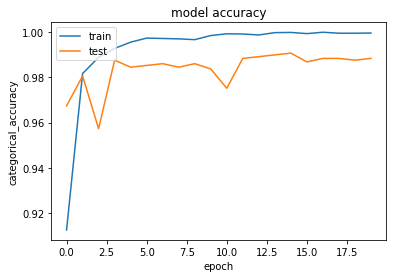

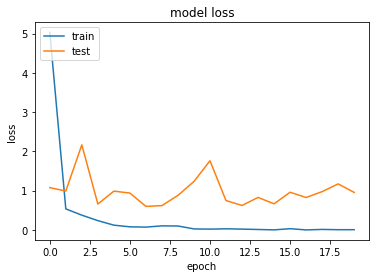

In [15]:
# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()